# MCM complexes are barriers that restrict cohesin-mediated loop extrusion

<img style="float: left;" src="https://icons.iconarchive.com/icons/dan-wiersma/solar-system/48/Mars-icon.png">

## Jupyter notebooks 

#### Figures:
+ 3
+ S9

#### Archives:
+ Cohesin-MCM_wt_highsalt.yama
+ Cohesin-MCM_wt_lowsalt.yama
+ Cohesin-only_lowsalt.yama

#### Additional data:
+ none

### Initialize ImageJ

In [1]:
import imagej
ij = imagej.init('/Applications/Fiji_MARS-beta18.app')
ij.getVersion()

'2.1.0/1.53c'

### Imports

In [2]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import awesome_data
from marspy.convert.archive import DnaMoleculeArchive, instantiate_archive, describe_archives
from tqdm.notebook import tqdm
from functools import reduce
from scipy.stats import norm

marspy initialized.


### Select archives

In [3]:
selected_archives = ['Cohesin-MCM_wt_highsalt.yama',
                     'Cohesin-MCM_wt_lowsalt.yama',
                     'Cohesin-only_lowsalt.yama']

### Figure style and output directory

In [4]:
from figure_style import *

In [5]:
set_style_paper()

In [6]:
# change to desired output directory
dir_out = '/Volumes/pool-duderstadt/Matthias/git/PhD/data/MCM-cohesin barrier/NEW_150_Preliminary/Figures/SVGs/'
dir_out

'/Volumes/pool-duderstadt/Matthias/git/PhD/data/MCM-cohesin barrier/NEW_150_Preliminary/Figures/SVGs/'

### Instantiate selected archives

In [7]:
for archive in tqdm(selected_archives):
    instantiate_archive(archive, awesome_data.datasets)

MCM variant not found. Setting default to n/a



### Add df_noidle to all molecules

In [8]:
for archive in tqdm(DnaMoleculeArchive.instances):
    
    archive.add_df_noidle(prefix='Cohesin_1_', specifier='idle')
    

### Archives Overview

In [9]:
describe_archives(DnaMoleculeArchive.instances)

,# of datasets,# of molecules,labeled proteins,nucleotide,NaCl concentration,MCM variant,archive validation
Cohesin-MCM_wt_highsalt,12,106,Halo-JF546-Cohesin; ybbR-LD655-MCM,ATP,500 mM,wt,passed
Cohesin-MCM_wt_lowsalt,20,181,Halo-JF546-Cohesin; ybbR-LD655-MCM,ATP,150 mM,wt,passed
Cohesin-only_lowsalt,4,59,Halo-JF546-Cohesin,ATP,150 mM,n/a,passed


### Functions

In [10]:
def calc_msd(df, prefix, msd_col, time_col, tau=1, start=np.nan, end=np.nan):
    """
    Calculates mean square displacement of molecules.
    Remove pairs with missing frames in interval, do not drop NaN values!
    *df: dataframe
    *prefix: protein prefix
    *msd_col: column in df to calculate msd (without protein prefix!)
    *time_col: time column in df (without protein prefix!)
    *tau: time delta used to calculate msd (without protein prefix!)
    *ignore_region: provide region name (regex) which is ignored for msd calculation (default False)
    
    returns (msd, dtime)
    msd: mean squared error
    dtime: mean time difference underlying msd calculation
    """
    
    # if not start / end was specified by used, set to max range
    if np.isnan(start):
        #start=df[prefix+time_col].iloc[0]
        start=df[prefix+time_col].min()
        
    if np.isnan(end):
        #end=df[prefix+time_col].iloc[-1]
        end=df[prefix+time_col].max()
        
    # will be a more accurate way to calculate MSD due to existing NaN values
    diffs = []
    dtimes = []
    for row in df.index:
        try:
            # check if sliding window range
            if (df.loc[row, prefix+time_col] >= start and df.loc[row+tau, prefix+time_col] <= end):

                # check if we have consecutive frames (T) which are not null
                if (((df.loc[row+tau, prefix+'T'] - df.loc[row, prefix+'T']) == tau) and not
                    ((np.isnan(df.loc[row+tau, prefix+msd_col]) or np.isnan(df.loc[row, prefix+msd_col])))):

                    diffs.append(df.loc[row+tau, prefix+msd_col] - df.loc[row, prefix+msd_col])
                    dtimes.append(df.loc[row+tau, prefix+time_col] - df.loc[row, prefix+time_col])

                else:
                    #skip to next row
                    continue

        # end of df
        except KeyError:
            break
            
    return np.mean(np.square(diffs)), np.mean(dtimes)

In [11]:
def calc_msd_raw(df, prefix, msd_col, time_col, tau=1, start=np.nan, end=np.nan):
    """
    Calculates mean square displacement of molecules.
    Remove pairs with missing frames in interval, do not drop NaN values!
    *df: dataframe
    *prefix: protein prefix
    *msd_col: column in df to calculate msd (without protein prefix!)
    *time_col: time column in df (without protein prefix!)
    *tau: time delta used to calculate msd (without protein prefix!)
    *ignore_region: provide region name (regex) which is ignored for msd calculation (default False)
    
    returns (msd, dtime)
    msd: mean squared error
    dtime: mean time difference underlying msd calculation
    """
    
    # if not start / end was specified by used, set to max range
    if np.isnan(start):
        #start=df[prefix+time_col].iloc[0]
        start=df[prefix+time_col].min()
        
    if np.isnan(end):
        #end=df[prefix+time_col].iloc[-1]
        end=df[prefix+time_col].max()
        
    # will be a more accurate way to calculate MSD due to existing NaN values
    diffs = []
    dtimes = []
    for row in df.index:
        try:
            # check if sliding window range
            if (df.loc[row, prefix+time_col] >= start and df.loc[row+tau, prefix+time_col] <= end):

                # check if we have consecutive frames (T) which are not null
                if (((df.loc[row+tau, prefix+'T'] - df.loc[row, prefix+'T']) == tau) and not
                    ((np.isnan(df.loc[row+tau, prefix+msd_col]) or np.isnan(df.loc[row, prefix+msd_col])))):

                    diffs.append(df.loc[row+tau, prefix+msd_col] - df.loc[row, prefix+msd_col])
                    dtimes.append(df.loc[row+tau, prefix+time_col] - df.loc[row, prefix+time_col])

                else:
                    #skip to next row
                    continue

        # end of df
        except KeyError:
            break
            
    return np.square(np.array(diffs))/(2*np.array(dtimes))

In [12]:
def calc_ars1_encounters(molecule):
    """
    Calculates encounters and encounter outcomes with ARS1 for a molecule object.
    """
    
    #reset to 0 in case it reruns
    #visualized encounters
    molecule.ars1_encounters_vis = 0
    
    #passage events
    molecule.ars1_pass = 0
    
    #blocking events
    molecule.ars1_block = 0
    
    #time between consecutive passage events
    molecule.pass_times = []
    
    #observation time
    molecule.timespan = (molecule.df[molecule.df['Cohesin_1_slice'] == molecule.params['Cohesin_1_last_slice']]['Cohesin_1_Time (s)'].iloc[0]-
                         molecule.df.loc[0,'Cohesin_1_Time (s)'])
    
    
    #get number of theoretical encounters with ARS1 from cohesin only molecules
    if 'ars1_mcm' in molecule.tags:
        pos_ars1 = molecule.df['MCM_1_Position_on_DNA'].mean()
          
    else:
        pos_ars1 = 5557.5

    for row in molecule.df.index:
        
        try:
            #direct collision
            if abs(molecule.df.loc[row,'Cohesin_1_Position_on_DNA'] - pos_ars1) < 1500:
                
                molecule.ars1_encounters_vis+=1

                #passed
                if (molecule.df.loc[row,'Cohesin_1_Position_on_DNA']<pos_ars1<molecule.df.loc[row+1,'Cohesin_1_Position_on_DNA']-500 or 
                    molecule.df.loc[row,'Cohesin_1_Position_on_DNA']>pos_ars1>molecule.df.loc[row+1,'Cohesin_1_Position_on_DNA']+500):
                    
                    molecule.ars1_pass+=1
                    molecule.pass_times.append(molecule.df.loc[row+1,'Cohesin_1_Time (s)'])

                #blocked
                else:
                    molecule.ars1_block+=1

            #no direct collision
            else:

                if (molecule.df.loc[row,'Cohesin_1_Position_on_DNA']<pos_ars1<molecule.df.loc[row+1,'Cohesin_1_Position_on_DNA']-500) or (
                    molecule.df.loc[row,'Cohesin_1_Position_on_DNA']>pos_ars1>molecule.df.loc[row+1,'Cohesin_1_Position_on_DNA']+500):
            
                    molecule.ars1_encounters_vis+=1
                    molecule.ars1_pass+=1
                    molecule.pass_times.append(molecule.df.loc[row+1,'Cohesin_1_Time (s)'])

        except KeyError:
            #print('last row reached, skip.')
            pass
    
    #calculate difference between passage times
    molecule.pass_diff = np.diff(molecule.pass_times,n=1)

### Generate main df

In [176]:
def setup_pandas_df(archive_instances):
    '''Sets up a 2-level df with all relevant information'''
    #indices will be UIDs
    #outside: set comprehension to cover all possible prefixes in all instances
    prefixes = set()
    for archive in archive_instances:
        prefixes.update(archive.prefixes)
    col_1 = sorted(list(prefixes))
    #inside
    col_2 = ['lifetime', 'initial_intensity', 'msd', 'dtime', 'd_coeff']

    hier_index = pd.MultiIndex.from_product([col_1,col_2],names=['molecule','properties'])

    return pd.DataFrame(columns=hier_index)

In [177]:
df = setup_pandas_df(DnaMoleculeArchive.instances)

# sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)
df.head()

Empty DataFrame
Columns: [(Cohesin_1_, d_coeff), (Cohesin_1_, dtime), (Cohesin_1_, initial_intensity), (Cohesin_1_, lifetime), (Cohesin_1_, msd), (MCM_1_, d_coeff), (MCM_1_, dtime), (MCM_1_, initial_intensity), (MCM_1_, lifetime), (MCM_1_, msd)]
Index: []

In [178]:
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        # general columns first
        df.loc[molecule.uid,'dna_length'] = molecule.calc_length_dna()
        df.loc[molecule.uid,'nucleotide'] = archive.nucleotide
        df.loc[molecule.uid,'nacl'] = archive.nacl
        
        # assign MCM variant and change to n/a for molecules without MCM on DNA
        try:
            if molecule.proteins['MCM'] > 0:
                df.loc[molecule.uid,'MCM_variant'] = archive.mcm
            else:
                df.loc[molecule.uid,'MCM_variant'] = 'n/a'
        except KeyError:
            # archive has 'n/a' by default
            df.loc[molecule.uid,'MCM_variant'] = archive.mcm
        
        try:
            df.loc[molecule.uid,'MCM_bleaching_steps'] = molecule.params['MCM_bleaching_steps']
        except KeyError:
            pass
        
        df.loc[molecule.uid,'tags'] = reduce(lambda tag1,tag2: tag1+','+tag2, molecule.tags)

        # general proteins
        for protein in molecule.proteins:
            #store protein number
            df.loc[molecule.uid,'number_'+protein] = molecule.params['Number_'+protein]
            #assign label for each protein
            df.loc[molecule.uid,'label_'+protein] = archive.labels[protein]
            
            
        # every specific protein
        for prefix in molecule.prefixes:

            #take mean intensity from first 10 frames (maybe need try block later if shorter traces)
            df.loc[molecule.uid,(prefix,'initial_intensity')] = molecule.df.iloc[:5][prefix+'Intensity'].mean()

            #observation time (in s) defined by tracking length
            df.loc[molecule.uid,(prefix,'timespan_(s)')] = molecule.df.filter(regex=prefix).dropna()[prefix+'Time_(s)'].max()
            
            # average position on DNA (try mean but might switch to median due to noise)
            df.loc[molecule.uid,(prefix,'avg_position_on_dna')] = molecule.df[prefix+'Position_on_DNA'].mean()
            
            # MSD (kbp^2) & dtime (s)    
            msd, dtime = calc_msd(df=molecule.df_noidle, prefix=prefix, msd_col='Position_on_DNA', time_col='Time_(s)', 
                                  tau=1)
            df.loc[molecule.uid,(prefix,'msd')] = msd/(1000**2)
            df.loc[molecule.uid,(prefix,'dtime')] = dtime

            # diffusion coefficient (kbp^2/s)
            df.loc[molecule.uid,(prefix,'d_coeff')] = df.loc[molecule.uid,(prefix,'msd')] / (2*df.loc[molecule.uid,(prefix,'dtime')])
            
            # pauses:
            # number of pauses
            #- do not consider pauses with less than 25 frames (region.end - region.start)
            
            df.loc[molecule.uid,(prefix,'number_pauses')] = len(list(filter(
                lambda region: ('idle' in region.name) and (region.prefix == prefix) and 
                (region.end - region.start >= 25), molecule.regions)))
            
            # cumulative pause duration
            cum_duration = 0
            
            for region in molecule.regions:
                
                # check again for the right regions, prefixes and duration
                if ('idle' in region.name) and (region.prefix == prefix) and (region.end - region.start >= 25):
                    
                    cum_duration += (molecule.df[molecule.df[region.prefix+region.column] == region.end][region.prefix+'Time_(s)'].item() - 
                                     molecule.df[molecule.df[region.prefix+region.column] == region.start][region.prefix+'Time_(s)'].item())
            
            df.loc[molecule.uid,(prefix,'cum_pause_duration_(s)')] = cum_duration
            
            # fraction of trajectory protein being idle
            df.loc[molecule.uid,(prefix,'fraction_idle')] = (df.loc[molecule.uid,(prefix,'cum_pause_duration_(s)')] /
                                                             df.loc[molecule.uid,(prefix,'timespan_(s)')])
        
# convert tags back to list
df['tags'] = df['tags'].apply(lambda tags: tags.split(','))

# replace NaN values for number_MCM with 0, then rename and convert to boolean
df['number_MCM'] = df['number_MCM'].apply(lambda value: 0 if np.isnan(value) else value)
df['MCM_at_origin'] = df['number_MCM'].apply(lambda value: value>=1)

# again sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)

# fix data types
df = df.infer_objects()


In [179]:
df

molecule                        Cohesin_1_                                    \
properties             avg_position_on_dna cum_pause_duration_(s)    d_coeff   
2PFd8LrNDti9JB4QSh3mR9        10644.210476                    0.0  19.546419   
2QGskSzFLzrBr7YLN78knZ        11142.190365                    0.0  29.767491   
2Z4r51hJSvdkiVDjjqKUrj         7348.886267                    0.0  43.310971   
2sTgZedaFFf9CK5b3GF6Cn        12755.246844                    0.0  52.460617   
3AoBkpRczab2PADB4kryfY        12054.104532                    0.0  23.531469   
...                                    ...                    ...        ...   
uD2qeX3fcDrkHLrEykKP3x        11509.738841                    0.0  19.707632   
uwCQQd5mMKFh5gQwnP9b3p        10813.865049                    0.0  22.283112   
vbQbfgRcaVUyxLdweJ2Y7p        10364.155308                    0.0  11.486890   
xcfK4nJ1oobZtYbMGVJHYQ        12603.288771                    0.0   3.351588   
xtREv4R9FAjgZ88vrbJPJM        10339.047184                    0.0  18.089110   

molecule                                                                   \
properties                 dtime fraction_idle initial_intensity lifetime   
2PFd8LrNDti9JB4QSh3mR9  0.187930           0.0           86644.6      NaN   
2QGskSzFLzrBr7YLN78knZ  0.182752           0.0           29989.5      NaN   
2Z4r51hJSvdkiVDjjqKUrj  0.183297           0.0           19703.6      NaN   
2sTgZedaFFf9CK5b3GF6Cn  0.184878           0.0            9802.7      NaN   
3AoBkpRczab2PADB4kryfY  0.184084           0.0           33791.1      NaN   
...                          ...           ...               ...      ...   
uD2qeX3fcDrkHLrEykKP3x  0.185782           0.0           24928.3      NaN   
uwCQQd5mMKFh5gQwnP9b3p  0.186097           0.0           42789.6      NaN   
vbQbfgRcaVUyxLdweJ2Y7p  0.185274           0.0           11532.8      NaN   
xcfK4nJ1oobZtYbMGVJHYQ  0.185053           0.0           12821.3      NaN   
xtREv4R9FAjgZ88vrbJPJM  0.186255           0.0           23820.3      NaN   

molecule                                                      ...  \
properties                    msd number_pauses timespan_(s)  ...   
2PFd8LrNDti9JB4QSh3mR9   7.346713           0.0      112.570  ...   
2QGskSzFLzrBr7YLN78knZ  10.880131           0.0      216.561  ...   
2Z4r51hJSvdkiVDjjqKUrj  15.877540           0.0      218.490  ...   
2sTgZedaFFf9CK5b3GF6Cn  19.397633           0.0       37.900  ...   
3AoBkpRczab2PADB4kryfY   8.663536           0.0      216.851  ...   
...                           ...           ...          ...  ...   
uD2qeX3fcDrkHLrEykKP3x   7.322659           0.0      204.550  ...   
uwCQQd5mMKFh5gQwnP9b3p   8.293621           0.0      222.751  ...   
vbQbfgRcaVUyxLdweJ2Y7p   4.256441           0.0       81.171  ...   
xcfK4nJ1oobZtYbMGVJHYQ   1.240442           0.0      210.860  ...   
xtREv4R9FAjgZ88vrbJPJM   6.738368           0.0      104.430  ...   

molecule               MCM_bleaching_steps MCM_variant dna_length  \
properties                                                          
2PFd8LrNDti9JB4QSh3mR9                 4.0          wt  38.988975   
2QGskSzFLzrBr7YLN78knZ                 NaN         n/a  43.426647   
2Z4r51hJSvdkiVDjjqKUrj                 2.0          wt  36.079005   
2sTgZedaFFf9CK5b3GF6Cn                 NaN         n/a  31.864820   
3AoBkpRczab2PADB4kryfY                 2.0          wt  42.316194   
...                                    ...         ...        ...   
uD2qeX3fcDrkHLrEykKP3x                 NaN         n/a  37.013511   
uwCQQd5mMKFh5gQwnP9b3p                 NaN         n/a  35.057096   
vbQbfgRcaVUyxLdweJ2Y7p                 NaN         n/a  36.667045   
xcfK4nJ1oobZtYbMGVJHYQ                 NaN         n/a  31.016125   
xtREv4R9FAjgZ88vrbJPJM                 NaN         n/a  36.013886   

molecule               label_Cohesin   label_MCM    nacl nucleotide  \
properties                                                            
2PFd8LrNDti9JB4QSh3

In [59]:
df[(df['nacl']=='150 mM') & (df['number_MCM'] == 1)]

molecule                        Cohesin_1_                       \
properties             avg_position_on_dna    d_coeff     dtime   
26g3CemDSKTjJiNz2xy5P          4406.634988   4.334230  0.182436   
2EepcrQfakuKUFLrxzzFAQ         8424.937570  46.397234  0.185371   
2chLcoDWzYU96Zd3bZK69n        11477.467862   7.437264  0.185528   
2dGBGxYFmKsAkuimnTz7P4        18342.998319   2.556944  0.188171   
2sn8zFDmyArfcDb6L1pvBD         2951.243359   3.287720  0.181901   
...                                    ...        ...       ...   
x3j6Uqgdf4Tk59ZYQeJN8N         2435.017301   4.628464  0.182433   
x6UZ52S8N8jx4eoQ4cBok         13514.196345   5.676487  0.188425   
xAA8jGu94f3JqWUbsAYbtQ         4013.661169   2.183648  0.185281   
xiGDn8nbuKXy3RrPGfk63z        10785.005161  14.302017  0.188686   
xomuXbExG9RPcxutCS7AAb        13678.018427  23.669868  0.185991   

molecule                                                      \
properties             initial_intensity lifetime        msd   
26g3CemDSKTjJiNz2xy5P             8985.9      366   1.581438   
2EepcrQfakuKUFLrxzzFAQ           29505.4     1185  17.201412   
2chLcoDWzYU96Zd3bZK69n            6906.1     1141   2.759637   
2dGBGxYFmKsAkuimnTz7P4           47689.7     1119   0.962284   
2sn8zFDmyArfcDb6L1pvBD            9513.9     1176   1.196080   
...                                  ...      ...        ...   
x3j6Uqgdf4Tk59ZYQeJN8N            9190.7      835   1.688767   
x6UZ52S8N8jx4eoQ4cBok            26897.2     1150   2.139181   
xAA8jGu94f3JqWUbsAYbtQ            9509.1      428   0.809178   
xiGDn8nbuKXy3RrPGfk63z           10289.7      934   5.397189   
xomuXbExG9RPcxutCS7AAb            9130.2     1137   8.804763   

molecule                            MCM_1_                      \
properties             avg_position_on_dna   d_coeff     dtime   
26g3CemDSKTjJiNz2xy5P          5274.280214  0.341654  0.182651   
2EepcrQfakuKUFLrxzzFAQ         5037.222604  0.201490  0.185762   
2chLcoDWzYU96Zd3bZK69n         3816.504394  0.203234  0.185429   
2dGBGxYFmKsAkuimnTz7P4        13405.407154  3.769165  0.188174   
2sn8zFDmyArfcDb6L1pvBD         6600.087405  1.996414  0.181737   
...                                    ...       ...       ...   
x3j6Uqgdf4Tk59ZYQeJN8N         5121.407218  0.419354  0.183002   
x6UZ52S8N8jx4eoQ4cBok          5719.107220  0.147816  0.188421   
xAA8jGu94f3JqWUbsAYbtQ         5879.609915  0.380073  0.185332   
xiGDn8nbuKXy3RrPGfk63z        17113.327547  1.351352  0.189509   
xomuXbExG9RPcxutCS7AAb         5162.851606  0.135989  0.187862   

molecule                                  ... MCM_bleaching_steps MCM_variant  \
properties             initial_intensity  ...                                   
26g3CemDSKTjJiNz2xy5P            13699.5  ...                 2.0          wt   
2EepcrQfakuKUFLrxzzFAQ           20569.4  ...                 4.0          wt   
2chLcoDWzYU96Zd3bZK69n           19309.0  ...                 2.0          wt   
2dGBGxYFmKsAkuimnTz7P4            9679.5  ...                 3.0          wt   
2sn8zFDmyArfcDb6L1pvBD           15220.5  ...                 2.0          wt   
...                                  ...  ...                 ...         ...   
x3j6Uqgdf4Tk59ZYQeJN8N           15568.7  ...                 4.0          wt   
x6UZ52S8N8jx4eoQ4cBok            10153.0  ...                 1.0          wt   
xAA8jGu94f3JqWUbsAYbtQ           29217.3  ...                 4.0          wt   
xiGDn8nbuKXy3RrPGfk63z            8703.4  ...                 2.0          wt   
xomuXbExG9RPcxutCS7AAb           18392.2  ...                 3.0          wt   

molecule               dna_length label_Cohesin   label_MCM    nacl  \
properties                                                            
26g3CemDSKTjJiNz2xy5P   35.014283    Halo-JF546  ybbR-LD655  150 mM   
2EepcrQfakuKUFLrxzzFAQ  37.000000    Halo-JF546  ybbR-LD655  150 mM   
2chLcoDWzYU96Zd3bZK69n  33.015148    Halo-JF546  ybbR-LD655  150 mM   
2dGBGxYFmKsAkuimnTz7P4  40.

## EDA

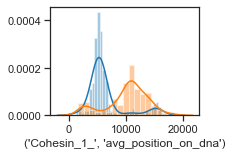

In [60]:
sns.distplot(df[('MCM_1_','avg_position_on_dna')])
sns.distplot(df[('Cohesin_1_','avg_position_on_dna')])

(-10.0, 100.0)

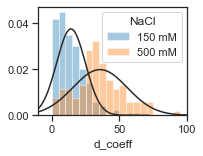

In [61]:
sns.distplot(df[df['nacl']=='150 mM']['Cohesin_1_']['d_coeff'], kde=False, fit=norm, bins=np.linspace(0,100,21), label='150 mM')
sns.distplot(df[df['nacl']=='500 mM']['Cohesin_1_']['d_coeff'], kde=False, fit=norm, bins=np.linspace(0,100,21), label='500 mM')
plt.legend(title='NaCl')
plt.xlim(-10,100)

In [19]:
sns.set_context('notebook')

In [21]:
df['nacl'].value_counts().sort_index()

150 mM    240
500 mM    106
Name: nacl, dtype: int64

In [24]:
df.groupby(['nacl','number_MCM']).describe()

molecule          Cohesin_1_                                             \
properties           d_coeff                                              
                       count       mean        std       min        25%   
nacl   number_MCM                                                         
150 mM 0.0              71.0  14.988253   9.765985  0.302461   7.567094   
       1.0             169.0  13.855721  11.011603  0.104246   5.240610   
500 mM 0.0              40.0  39.881477  22.503749  1.261721  27.962753   
       1.0              66.0  33.107011  18.325147  3.314084  20.133066   

molecule                                                              ...  \
properties                                           dtime            ...   
                         50%        75%         max  count      mean  ...   
nacl   number_MCM                                                     ...   
150 mM 0.0         12.529392  21.493836   47.154546   71.0  0.185531  ...   
       1.0         11.338895  19.145256   61.069531  169.0  0.186159  ...   
500 mM 0.0         33.675760  50.871664  135.338213   40.0  0.183505  ...   
       1.0         33.765654  43.285031   90.804718   66.0  0.183465  ...   

molecule          number_Cohesin      number_MCM                           \
properties                                                                  
                             75%  max      count mean  std  min  25%  50%   
nacl   number_MCM                                                           
150 mM 0.0                   1.0  1.0       71.0  0.0  0.0  0.0  0.0  0.0   
       1.0                   1.0  1.0      169.0  1.0  0.0  1.0  1.0  1.0   
500 mM 0.0                   1.0  1.0       40.0  0.0  0.0  0.0  0.0  0.0   
       1.0                   1.0  1.0       66.0  1.0  0.0  1.0  1.0  1.0   

molecule                     
properties                   
                   75%  max  
nacl   number_MCM            
150 mM 0.0         0.0  0.0  
       1.0         1.0  1.0  
500 mM 0.0         0.0  0.0  
       1.0         1.0  1.0  

[4 rows x 112 columns]

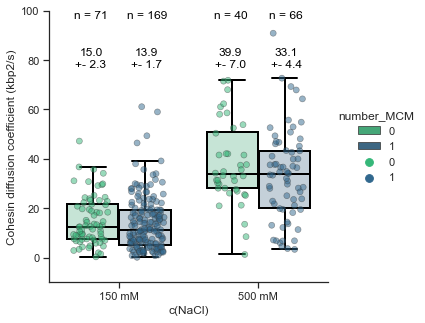

In [25]:
sns.set_context('notebook')
# Cohesin diffusion coefficient
fig,axes = plt.subplots(figsize=(5,5))


#setup style

#boxprops = {'edgecolor': 'k', 'linewidth': 2, 'facecolor': 'w'}
boxprops = {'edgecolor': 'k', 'linewidth': 2}
lineprops = {'color': 'k', 'linewidth': 2}
kwargs = {'palette': 'viridis_r', 'hue_order': [0, 1]}

boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops,
                       'width': 0.75},
                      **kwargs)

stripplot_kwargs = dict({'linewidth': 0.6, 'size': 6, 'alpha': 0.5},
                        **kwargs)



sns.boxplot(x='nacl', y=('Cohesin_1_','d_coeff'), hue='number_MCM',data=df, ax=axes,
           order=['150 mM', '500 mM'], fliersize=0, **boxplot_kwargs)
sns.stripplot(x='nacl', y=('Cohesin_1_','d_coeff'), hue='number_MCM',data=df, ax=axes,
           order=['150 mM', '500 mM'], dodge=True, jitter=0.25, **stripplot_kwargs)
#axes[1].artists
#axes.set_xlim(0,100)
axes.set_ylim(-10,100)
axes.set_xlabel('c(NaCl)')
axes.set_ylabel('Cohesin diffusion coefficient (kbp2/s)')
axes.legend(bbox_to_anchor=[1, 0.5],frameon=False, title='number_MCM', loc='center left')


#calculate number of observations
nobs = df.groupby(['nacl','number_MCM']).size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]

# calculate mean and ci
diffusion = []
# fit data to normal distribution and print on plot
for nacl in df['nacl'].sort_values().unique():
    for num_mcm in df['number_MCM'].sort_values().unique():
        mean = df[(df['nacl']==nacl) & (df['number_MCM']==num_mcm)][('Cohesin_1_','d_coeff')].mean()
        sem = df[(df['nacl']==nacl) & (df['number_MCM']==num_mcm)][('Cohesin_1_','d_coeff')].sem()*1.96
        diffusion.append(f'{round(mean,1)}\n+- {round(sem,1)}')

#put nobs and diff values into plot

ind = 0
for tick in range(len(axes.get_xticklabels())):
    axes.text(tick-.2, 100, nobs[ind], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick+.2, 100, nobs[ind+1], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick-.2, 85, diffusion[ind], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick+.2, 85, diffusion[ind+1], horizontalalignment='center', verticalalignment='top', color='k')
    ind += 2

for patch in axes.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
#axes[1].set_title('Different labels do not affect RNAP transcription')
sns.despine()

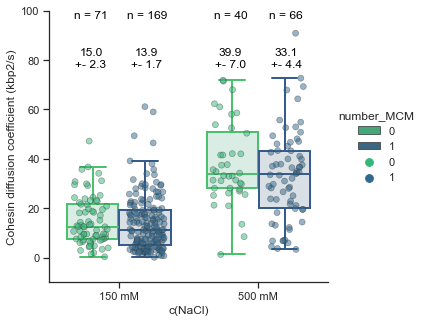

In [26]:
sns.set_context('notebook')
# Cohesin diffusion coefficient
fig,axes = plt.subplots(figsize=(5,5))


#setup style

#boxprops = {'edgecolor': 'k', 'linewidth': 2, 'facecolor': 'w'}
boxprops = {'edgecolor': 'k', 'linewidth': 2}
lineprops = {'color': 'k', 'linewidth': 2}
kwargs = {'palette': 'viridis_r', 'hue_order': [0, 1]}

boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops,
                       'width': 0.75},
                      **kwargs)

stripplot_kwargs = dict({'linewidth': 0.6, 'size': 6, 'alpha': 0.5},
                        **kwargs)



sns.boxplot(x='nacl', y=('Cohesin_1_','d_coeff'), hue='number_MCM',data=df, ax=axes,
           order=['150 mM', '500 mM'], fliersize=0, **boxplot_kwargs)
sns.stripplot(x='nacl', y=('Cohesin_1_','d_coeff'), hue='number_MCM',data=df, ax=axes,
           order=['150 mM', '500 mM'], dodge=True, jitter=0.25, **stripplot_kwargs)
#axes[1].artists
#axes.set_xlim(0,100)
axes.set_ylim(-10,100)
axes.set_xlabel('c(NaCl)')
axes.set_ylabel('Cohesin diffusion coefficient (kbp2/s)')
axes.legend(bbox_to_anchor=[1, 0.5],frameon=False, title='number_MCM', loc='center left')


#calculate number of observations
nobs = df.groupby(['nacl','number_MCM']).size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]

# calculate mean and ci
diffusion = []
# fit data to normal distribution and print on plot
for nacl in df['nacl'].sort_values().unique():
    for num_mcm in df['number_MCM'].sort_values().unique():
        mean = df[(df['nacl']==nacl) & (df['number_MCM']==num_mcm)][('Cohesin_1_','d_coeff')].mean()
        sem = df[(df['nacl']==nacl) & (df['number_MCM']==num_mcm)][('Cohesin_1_','d_coeff')].sem()*1.96
        diffusion.append(f'{round(mean,1)}\n+- {round(sem,1)}')

#put nobs and diff values into plot

ind = 0
for tick in range(len(axes.get_xticklabels())):
    axes.text(tick-.2, 100, nobs[ind], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick+.2, 100, nobs[ind+1], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick-.2, 85, diffusion[ind], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick+.2, 85, diffusion[ind+1], horizontalalignment='center', verticalalignment='top', color='k')
    ind += 2

for patch in axes.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .2))
    
#axes[1].set_title('Different labels do not affect RNAP transcription')
sns.despine()

for i, artist in enumerate(axes.artists):
    if i % 2 == 0:
        col = sns.color_palette('viridis_r')[1]
    else:
        col = sns.color_palette('viridis_r')[-2]

    # This sets the color for the main box
    artist.set_edgecolor(col)
    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = axes.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)
        

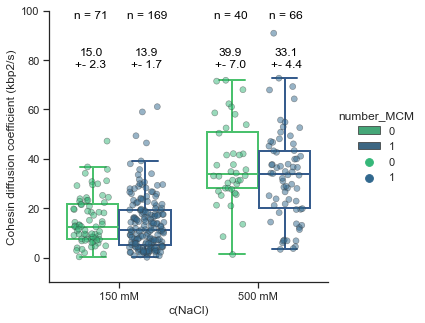

In [27]:
sns.set_context('notebook')
# Cohesin diffusion coefficient
fig,axes = plt.subplots(figsize=(5,5))


#setup style

boxprops = {'edgecolor': 'k', 'linewidth': 2, 'facecolor': 'w'}
lineprops = {'color': 'k', 'linewidth': 2}
kwargs = {'palette': 'viridis_r', 'hue_order': [0, 1]}

boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops,
                       'width': 0.75},
                      **kwargs)

stripplot_kwargs = dict({'linewidth': 0.6, 'size': 6, 'alpha': 0.5},
                        **kwargs)



sns.boxplot(x='nacl', y=('Cohesin_1_','d_coeff'), hue='number_MCM',data=df, ax=axes,
           order=['150 mM', '500 mM'], fliersize=0, **boxplot_kwargs)
sns.stripplot(x='nacl', y=('Cohesin_1_','d_coeff'), hue='number_MCM',data=df, ax=axes,
           order=['150 mM', '500 mM'], dodge=True, jitter=0.25, **stripplot_kwargs)
#axes[1].artists
#axes.set_xlim(0,100)
axes.set_ylim(-10,100)
axes.set_xlabel('c(NaCl)')
axes.set_ylabel('Cohesin diffusion coefficient (kbp2/s)')
axes.legend(bbox_to_anchor=[1, 0.5],frameon=False, title='number_MCM', loc='center left')

#calculate number of observations
nobs = df.groupby(['nacl','number_MCM']).size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]

# calculate mean and ci
diffusion = []
# fit data to normal distribution and print on plot
for nacl in df['nacl'].sort_values().unique():
    for num_mcm in df['number_MCM'].sort_values().unique():
        mean = df[(df['nacl']==nacl) & (df['number_MCM']==num_mcm)][('Cohesin_1_','d_coeff')].mean()
        sem = df[(df['nacl']==nacl) & (df['number_MCM']==num_mcm)][('Cohesin_1_','d_coeff')].sem()*1.96
        diffusion.append(f'{round(mean,1)}\n+- {round(sem,1)}')

#put nobs and diff values into plot

ind = 0
for tick in range(len(axes.get_xticklabels())):
    axes.text(tick-.2, 100, nobs[ind], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick+.2, 100, nobs[ind+1], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick-.2, 85, diffusion[ind], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick+.2, 85, diffusion[ind+1], horizontalalignment='center', verticalalignment='top', color='k')
    ind += 2

for patch in axes.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .2))
    
#axes[1].set_title('Different labels do not affect RNAP transcription')
sns.despine()

for i, artist in enumerate(axes.artists):
    if i % 2 == 0:
        col = sns.color_palette('viridis_r')[1]
    else:
        col = sns.color_palette('viridis_r')[-2]

    # This sets the color for the main box
    artist.set_edgecolor(col)
    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = axes.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

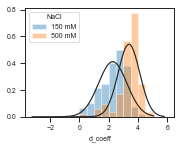

In [168]:
sns.distplot(np.log(df[df['nacl']=='150 mM']['Cohesin_1_']['d_coeff']), kde=False, fit=norm, bins=np.linspace(0,6,13), label='150 mM')
sns.distplot(np.log(df[df['nacl']=='500 mM']['Cohesin_1_']['d_coeff']), kde=False, fit=norm, bins=np.linspace(0,6,13), label='500 mM')
plt.legend(title='NaCl')

In [172]:
np.mean(df[df['nacl']=='150 mM']['Cohesin_1_']['d_coeff'])

13.706607921299318

In [173]:
np.mean(df[df['nacl']=='500 mM']['Cohesin_1_']['d_coeff'])

35.66341306264134

In [174]:
(df['Cohesin_1_']['d_coeff']).sem()*1.96

1.824088506209815

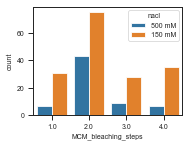

In [175]:
sns.countplot(x='MCM_bleaching_steps',hue='nacl',data=df)

In [322]:
# detect pauses
uid_short_pause = 'dUN9pxXhb5TkZuCPm17vAV'
uid_long_pause = 'cFtvPxQgKNfhoP3qVMW4S2'
uid_noisy_pause = '2EepcrQfakuKUFLrxzzFAQ'

In [323]:
# rules
# plot msd
# at least 5 seconds (roughly 25 frames)

In [346]:
mol1 = DnaMoleculeArchive.instances[1].get_molecule_by_uid(uid_long_pause)
mol2 = DnaMoleculeArchive.instances[1].get_molecule_by_uid(uid_short_pause)
mol3 = DnaMoleculeArchive.instances[1].get_molecule_by_uid(uid_noisy_pause)

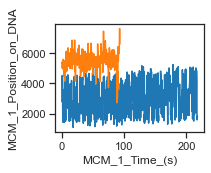

In [351]:
mol2.plot()

In [348]:
d_coeffs = calc_msd_raw(df=mol1.df, prefix='Cohesin_1_', msd_col='Position_on_DNA', time_col='Time_(s)', 
                                  tau=1)

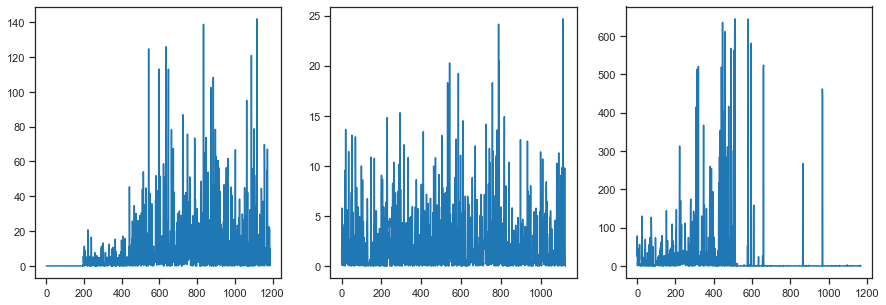

In [349]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
axes[0].plot(calc_msd_raw(df=mol1.df, prefix='Cohesin_1_', msd_col='Position_on_DNA', time_col='Time_(s)', 
                                  tau=1)/1000000)

axes[1].plot(calc_msd_raw(df=mol2.df, prefix='Cohesin_1_', msd_col='Position_on_DNA', time_col='Time_(s)', 
                                  tau=1)/1000000)

axes[2].plot(calc_msd_raw(df=mol3.df, prefix='Cohesin_1_', msd_col='Position_on_DNA', time_col='Time_(s)', 
                                  tau=1)/1000000)
#plt.yscale('log')


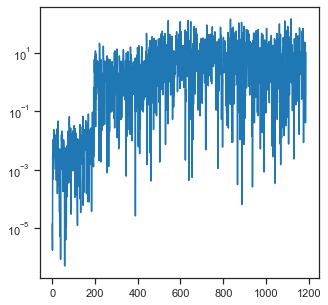

In [340]:
fig = plt.figure(figsize=(5,5))
plt.plot(d_coeffs/1000000)
plt.yscale('log')

(0.0, 5.0)

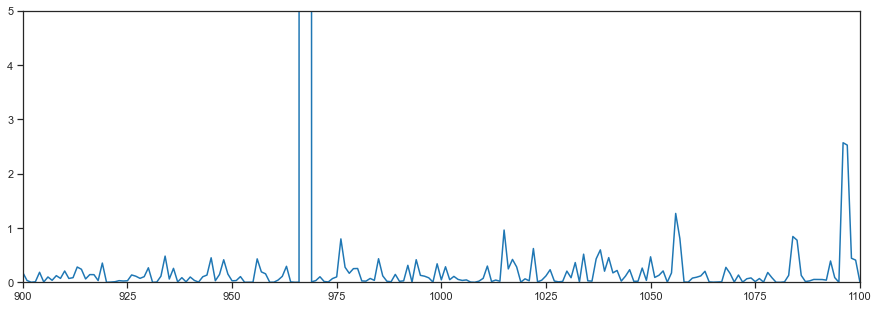

In [358]:
fig,axes = plt.subplots(figsize=(15,5))
plt.plot(calc_msd_raw(df=mol3.df, prefix='Cohesin_1_', msd_col='Position_on_DNA', time_col='Time_(s)', 
                                  tau=1)/1000000)
plt.xlim(900,1100)
plt.ylim(0,5)

Rolling [window=10,center=False,axis=0]

(0.0, 5.0)

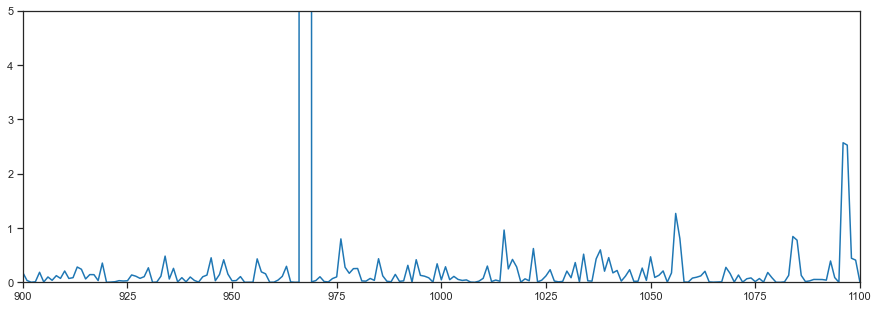

In [372]:
fig,axes = plt.subplots(figsize=(15,5))
plt.plot((calc_msd_raw(df=mol3.df, prefix='Cohesin_1_', msd_col='Position_on_DNA', time_col='Time_(s)', 
                                  tau=1)/1000000))
plt.xlim(900,1100)
plt.ylim(0,5)

In [28]:
# PAUSE REGIONS

In [64]:
pausing = []
times = []
for archive in DnaMoleculeArchive.instances[1:2]:
    for molecule in archive.molecules:
        
        pausing.append(len(molecule.regions))
        for region in molecule.regions:
            print(molecule.uid)
            times.append(region.end - region.start)

26g3CemDSKTjJiNz2xy5P
2EepcrQfakuKUFLrxzzFAQ
2dGBGxYFmKsAkuimnTz7P4
99ufFXuNVrAMCQS9XwUQUS
aipyCAN69ZfZwxxaxoGQrt
brrew4uKwLLn7xkxkE9scm
cFtvPxQgKNfhoP3qVMW4S2
d3J15heW4oRPfD65UvXNVj
dFdVKokd6HwadGjL2Uu6gG
dKpaCm6uMrJgcucU6XrZPJ
dvme6ySY8UTNfKqQvp4Njb
eJdrj5KPek4PtuHzdeHKqi
i1hX5dRdKM44Muw73BKJki
i2Q8kUVXKeKMMj2qFeeLSg
iM9TVZY91axtVWCb7RthDU
iM9TVZY91axtVWCb7RthDU
iXYttBNNocBmcTHnAwdjPS
jymn2za5bW9FGsZX9LQb62
k1emu2KxpQrsMd6rHxqtkm
kt7wkDSfijvAJFaBD831CY
kt7wkDSfijvAJFaBD831CY
mnLHYHVbqazA9yrcLA9cyM
mr48K2K1KKJDjnXhAW1DzP
nJGivnnE1QJnpdt1MMNhx
nJGivnnE1QJnpdt1MMNhx
pFiN4uWYo1CSiXbB5HwdNH
paa57GApusUX5mDx8hnGeN
ryhrFg7EePM9kLwuPm3P1R
uSBKk2MEiLtKvcMBmxFQHp
vbdiNtN35kXWC1ia8U4hFx


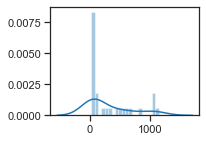

In [38]:
sns.distplot(times, bins=20)

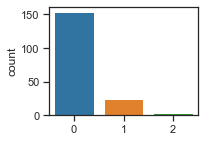

In [71]:
sns.countplot(pausing)

In [75]:
max(times)

1145.0

In [65]:
mol1 = DnaMoleculeArchive.instances[1].get_molecule_by_uid('26g3CemDSKTjJiNz2xy5P')

In [76]:
mol1.regions[0].prefix

'Cohesin_1_'

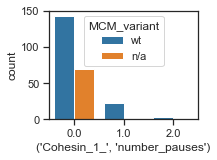

In [181]:
sns.countplot(x=('Cohesin_1_','number_pauses'), hue='MCM_variant',data=df[df['nacl']=='150 mM'])

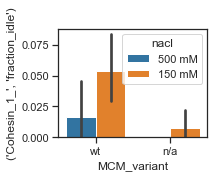

In [269]:
sns.barplot(x='MCM_variant', y=('Cohesin_1_','fraction_idle'), hue='nacl', data=df)

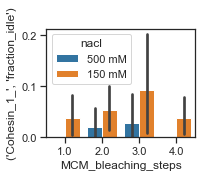

In [270]:
sns.barplot(x='MCM_bleaching_steps', y=('Cohesin_1_','fraction_idle'), hue='nacl', data=df)

In [162]:
df.columns

MultiIndex([(         'Cohesin_1_',    'avg_position_on_dna'),
            (         'Cohesin_1_', 'cum_pause_duration_(s)'),
            (         'Cohesin_1_',                'd_coeff'),
            (         'Cohesin_1_',                  'dtime'),
            (         'Cohesin_1_',          'fraction_idle'),
            (         'Cohesin_1_',      'initial_intensity'),
            (         'Cohesin_1_',               'lifetime'),
            (         'Cohesin_1_',                    'msd'),
            (         'Cohesin_1_',          'number_pauses'),
            (         'Cohesin_1_',           'timespan_(s)'),
            (             'MCM_1_',    'avg_position_on_dna'),
            (             'MCM_1_', 'cum_pause_duration_(s)'),
            (             'MCM_1_',                'd_coeff'),
            (             'MCM_1_',                  'dtime'),
            (             'MCM_1_',          'fraction_idle'),
            (             'MCM_1_',      'initial_inten

## setup df_pause

In [263]:
df_pause = pd.DataFrame(columns=['MCM_at_origin', 'MCM_bleaching_steps', 'MCM_variant', 'nacl', 
                                 'pause_duration','MCM_position_on_dna', 'pause_position_on_dna', 'pause_at_MCM'])   
df_pause

,MCM_at_origin,MCM_bleaching_steps,MCM_variant,nacl,pause_duration,MCM_position_on_dna,pause_position_on_dna,pause_at_MCM


In [264]:
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        # pauses:
        for region in molecule.regions:

            # check again for the right regions, prefixes and duration
            if ('idle' in region.name) and (region.prefix == 'Cohesin_1_') and (region.end - region.start >= 25):

                # temporary df
                _temp_df = pd.DataFrame()
                try:
                    _temp_df.loc[0,'MCM_at_origin'] = molecule.proteins['MCM'] > 0
                    _temp_df.loc[0,'MCM_bleaching_steps'] = molecule.params['MCM_bleaching_steps']
                    _temp_df.loc[0,'MCM_variant'] = archive.mcm
                    _temp_df.loc[0,'MCM_position_on_dna'] = molecule.df['MCM_1_Position_on_DNA'].median()
                except KeyError:
                    _temp_df.loc[0,'MCM_at_origin'] = False
                    _temp_df.loc[0,'MCM_variant'] = 'n/a'
                
                _temp_df.loc[0,'nacl'] = archive.nacl
                _temp_df.loc[0,'pause_duration'] = (molecule.df[molecule.df[region.prefix+region.column] == region.end][region.prefix+'Time_(s)'].item() - 
                                              molecule.df[molecule.df[region.prefix+region.column] == region.start][region.prefix+'Time_(s)'].item())
                
                _temp_df.loc[0,'pause_position_on_dna'] = molecule.df[(molecule.df[region.prefix+region.column] >= region.start) & 
                                                                (molecule.df[region.prefix+region.column] <= region.end)]['Cohesin_1_Position_on_DNA'].median()
 
                try:
                    _temp_df.loc[0,'pause_at_MCM'] = abs(_temp_df.loc[0,'MCM_position_on_dna'] - _temp_df.loc[0,'pause_position_on_dna']) <= 1500
                except KeyError:
                    pass
                         
            df_pause = pd.concat([df_pause, _temp_df])
            
# again sort MultiIndexCols for performance
df_pause.sort_index(axis=1, inplace=True)

# fix data types
df_pause = df_pause.infer_objects()

In [265]:
df_pause

,MCM_at_origin,MCM_bleaching_steps,MCM_position_on_dna,MCM_variant,nacl,pause_at_MCM,pause_duration,pause_position_on_dna
0,True,3.0,3536.266783,wt,500 mM,False,52.140,20173.783329
0,True,2.0,5107.475979,wt,500 mM,True,181.530,4840.273699
0,True,2.0,5273.016721,wt,150 mM,True,52.630,4932.590470
0,True,4.0,5049.834408,wt,150 mM,True,125.411,5164.722176
0,True,3.0,13035.814151,wt,150 mM,False,115.150,19359.930888
0,True,4.0,4958.434377,wt,150 mM,True,77.580,6106.968778
0,True,3.0,7077.017852,wt,150 mM,True,8.190,5596.728895
0,True,2.0,5324.481452,wt,150 mM,True,5.260,4700.725920
0,True,1.0,5529.985371,wt,150 mM,False,37.480,18250.571016
0,True,4.0,4791.776182,wt,150 mM,True,5.180,4098.946904


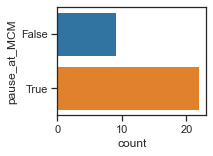

In [266]:
sns.countplot(y='pause_at_MCM', data=df_pause)

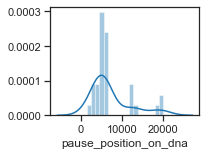

In [267]:
sns.distplot(df_pause['pause_position_on_dna'])

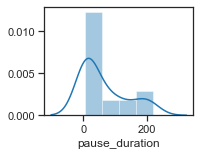

In [268]:
sns.distplot(df_pause['pause_duration'])

## Figures

### Figure 1B: ORC-MCM loading sites

In [ ]:
proteins = ['ORC','MCM']
pal_pos = 1

fig,axes = plt.subplots(len(proteins),1,sharex=True,sharey=True)

for i, protein in enumerate(proteins):
    sns.distplot(df.filter(regex=(protein+"_"),axis=1).xs('start_site',level='properties',axis=1)/1000,
                 label=f'{protein}',color=palettes[protein][pal_pos],bins = np.linspace(0, 25, 51), ax=axes[i])
    # mean+/- sem
    mean_start = pd.melt(df.filter(regex=(protein+"_"),axis=1).xs('start_site',level='properties',axis=1)/1000)['value'].median()
    sem_start = pd.melt(df.filter(regex=(protein+"_"),axis=1).xs('start_site',level='properties',axis=1)/1000)['value'].sem()
    axes[i].text(0.95, 0.85, f"mean = {round(mean_start,2)} $\pm$ {round(sem_start,2)} kb",
            verticalalignment='top', horizontalalignment='right',
            transform=axes[i].transAxes,color=palettes[protein][pal_pos])

    axes[i].text(0.95, 0.95, f"n = {len(pd.melt(df.filter(regex=(protein+'_'),axis=1).xs('start_site',level='properties',axis=1))['value'].dropna())}",
            verticalalignment='top', horizontalalignment='right',
            transform=axes[i].transAxes)

for ax in axes:
    ax.set_xlim(0,24)
    ax.set_ylim(0,0.75)
    ax.legend(frameon=False,loc=7)

fig.text(0.5, -0.04, 'Position on DNA (kb)', ha='center', rotation='horizontal')
fig.text(-0.04, 0.5, 'Probability density', va='center', rotation='vertical')

sns.despine()
#plt.tight_layout()

plt.savefig(dir_out+'1B_ORC-MCM_loading_sites.svg',transparent=True)
